

## Прогнозирование стоимости автомобиля по характеристикам


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import re

In [2]:
#показывать dataframe без ограничения количества столбцов и 100 строк по умолчанию
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.20.3


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
#функция для первичного анализа категориальных столбцов
def plot_str(df,col):

    print('Распределение для столбца (не числовой):', col)
    fig,ax=plt.subplots(figsize=(10,5))
    sns.countplot(x=df.loc[:,col], ax=ax)
    plt.show()
#поиск пустых  Nan значений в символьном  столбце, расчет процента потерянных значений
    n=100-(df[col].count()/df.shape[0]*100)
    print('уникальных значений ', len(df[col].dropna().unique()))
    print ('пустых значений,%', round(n,2))
    #df.default.unique()

# Setup

In [7]:
# VERSION    = 16
# DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключение к ноутбуку внешнего датасета
# DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

Загрузка данных

In [8]:
train = pd.read_csv('../input/parsing-all-moscow-auto-ru-09-09-2020/all_auto_ru_09_09_2020.csv') # датасет для обучения модели
# bigtrain = pd.read_csv('../input/data-add/data1.csv')
mtrain=train.copy()

#train_add = pd.read_csv('../input/data-add/data1.csv')
test = pd.read_csv('../input/sf-dst-car-price-prediction/test.csv')
mtest=test.copy()

mtest.rename(columns={'model_name': 'model'}, inplace=True)
sample_submission = pd.read_csv('../input/sf-dst-car-price-prediction/sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [10]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,NaN,240000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101.0,"Машина не гнилая, дыр нет, днище целое, даже в...",300000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Что может повлиять на стоимость

- 'bodyType' - тип кузова автомобиля, 
- 'brand', - производитель 
- 'fuelType' - тип топлива
- 'modelDate' - дата модели
- 'numberOfDoors' - количество дверей 
- 'productionDate' - дата производства
- 'vehicleTransmission' - вид трансмиссии 
- 'engineDisplacement' - объем двигателя 
- 'enginePower'- мощность двигателя
- 'mileage'- пробег 
- 'Привод'- привод 
- 'Руль' - руль
- 'ПТС' - наличеие ПТС 
- 'model' - модель

Числовые признаки : 'modelDate', 'productionDate', 'enginePower', 'mileage'.
Остальные признаки категориальные. 
Поэтому будем проводить моделирование в 2 вариантах: 
1. CatBoost, поскольку для ее использования не требуется делать hot encoding, подбор гиперпараметров по сетке.
2. Построение разрженной матрицы с помощью hot ecoding и тестирование различных ML библиотек.

Выбор модели с наилучшим результатом


**1. Исследуем признак - *'vehicleTransmission'***


Распределение для столбца (не числовой): vehicleTransmission


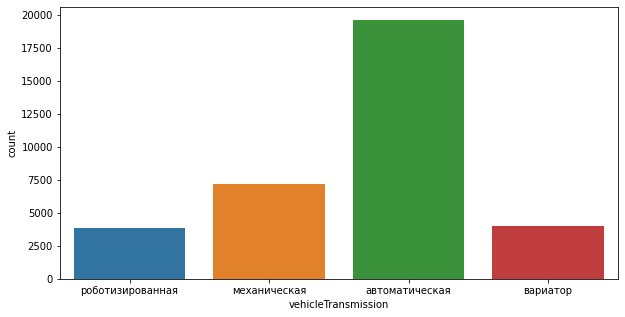

уникальных значений  4
пустых значений,% 0.0
Распределение для столбца (не числовой): vehicleTransmission


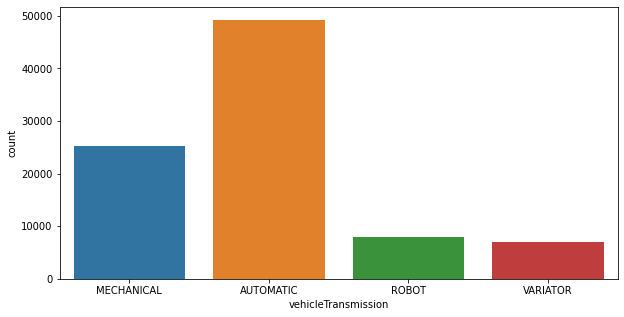

уникальных значений  4
пустых значений,% 0.0


In [12]:
mtest['vehicleTransmission'].value_counts()
plot_str(mtest,'vehicleTransmission')
plot_str(mtrain,'vehicleTransmission')

In [13]:
mtest.dropna(subset=['vehicleTransmission'], inplace=True)
#переименование данных  train и test

mtest.loc[mtest['vehicleTransmission'].str.contains("робот"),'vehicleTransmission'] =  "ROBOT"
mtest.loc[mtest['vehicleTransmission'].str.contains("мех"),'vehicleTransmission'] =  "MECHANICAL"
mtest.loc[mtest['vehicleTransmission'].str.contains("автомат"),'vehicleTransmission'] =  "AUTOMATIC"
mtest.loc[mtest['vehicleTransmission'].str.contains("вариат"),'vehicleTransmission'] =  "VARIATOR"
mtest.vehicleTransmission.value_counts()

AUTOMATIC     19596
MECHANICAL     7209
VARIATOR       3999
ROBOT          3882
Name: vehicleTransmission, dtype: int64

2. **Исследуем признак *'fuelType'***

In [14]:
mtest['fuelType'].value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

In [15]:
mtrain['fuelType'].value_counts()

бензин       75053
дизель       13907
гибрид         295
электро        111
газ             11
универсал        1
Name: fuelType, dtype: int64

расхождение в одно значение: универсал

In [16]:
mtrain[mtrain['fuelType']=='универсал']

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
24624,NaN,HONDA,CACECB,универсал,NaN,NaN,NaN,1989,NaN,NaN,NaN,NaN,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",400000,"{'id': '0', 'name': ''}",NaN,LEFT,NaN,3.0,ORIGINAL,True,NaN,120000.0,2020-04-10T16:07:57Z,NaN,CIVIC


эту строку можно вообще удалить, поскольку большинство значений NaN

In [17]:
mtrain.drop(labels = [24624], axis = 0, inplace = True)
mtrain['fuelType'].value_counts()

бензин     75053
дизель     13907
гибрид       295
электро      111
газ           11
Name: fuelType, dtype: int64

Распределение для столбца (не числовой): fuelType


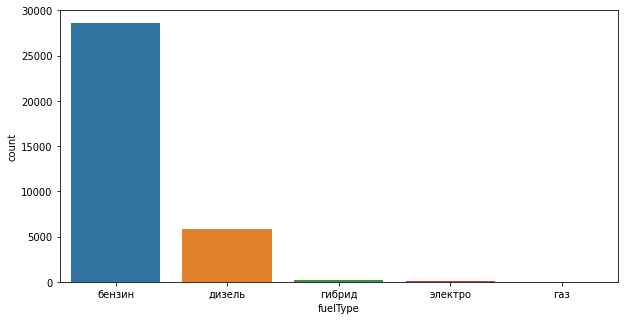

уникальных значений  5
пустых значений,% 0.0
Распределение для столбца (не числовой): fuelType


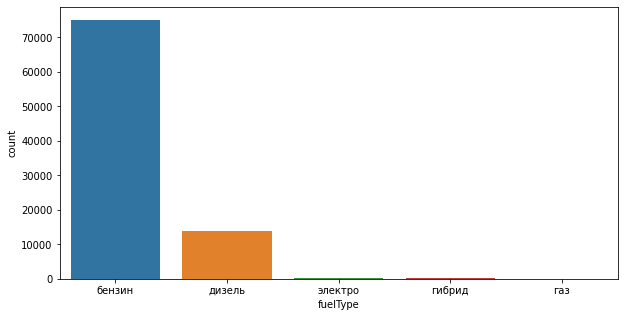

уникальных значений  5
пустых значений,% 0.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model                 34686 non-null  obj

In [18]:
plot_str(mtest,'fuelType')
plot_str(mtrain,'fuelType')
mtest.info()

**3. Признак *'numberOfDoors'*** 

Количество дверей в автомобиле. Спорно, но возможно будет влиять на стоимость авто, поскольку косвенно подтверждает модель.
проверим, улучшится ли оценка предсказания. Признак категориальный.


In [19]:
mtest[ 'numberOfDoors' ].value_counts()

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64

In [20]:
mtrain[ 'numberOfDoors' ].value_counts()

5.0    51625
4.0    33647
3.0     2211
2.0     1893
0.0        1
Name: numberOfDoors, dtype: int64

Здесь есть какое-то странное авто БЕЗ ДВЕРЕЙ.

In [21]:
mtrain[mtrain[ 'numberOfDoors' ]==0]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
88065,Кабриолет,MERCEDES,FAFBFB,бензин,1904.0,5.3 MT (32 л.с.),0.0,1904,CABRIO MECHANICAL 5.3,MECHANICAL,5.3,32.0,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",48000,{'id': '0'},задний,RIGHT,NaN,1.0,ORIGINAL,True,"{'year': 2014, 'month': 2}",12000000.0,2019-11-20T14:14:11Z,NaN,SIMPLEX


Это действительно реальный объект, есть в обеих выборках.

Распределение для столбца (не числовой): numberOfDoors


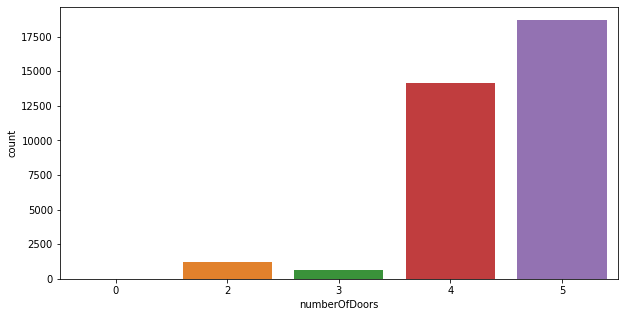

уникальных значений  5
пустых значений,% 0.0
Распределение для столбца (не числовой): numberOfDoors


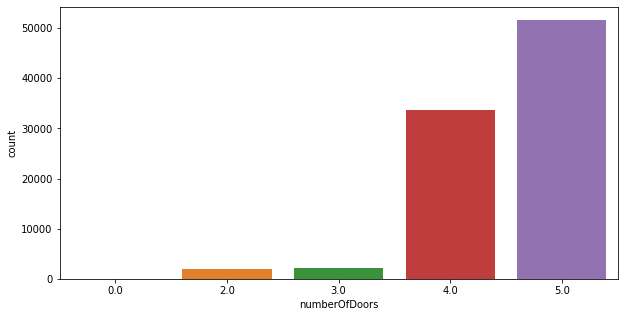

уникальных значений  5
пустых значений,% 0.0


In [22]:
plot_str(mtest, 'numberOfDoors')
plot_str(mtrain, 'numberOfDoors')

4. **Исследуем признак *'engineDisplacement' (объем двигателя)***: 

Распределение для столбца (не числовой):  engineDisplacement


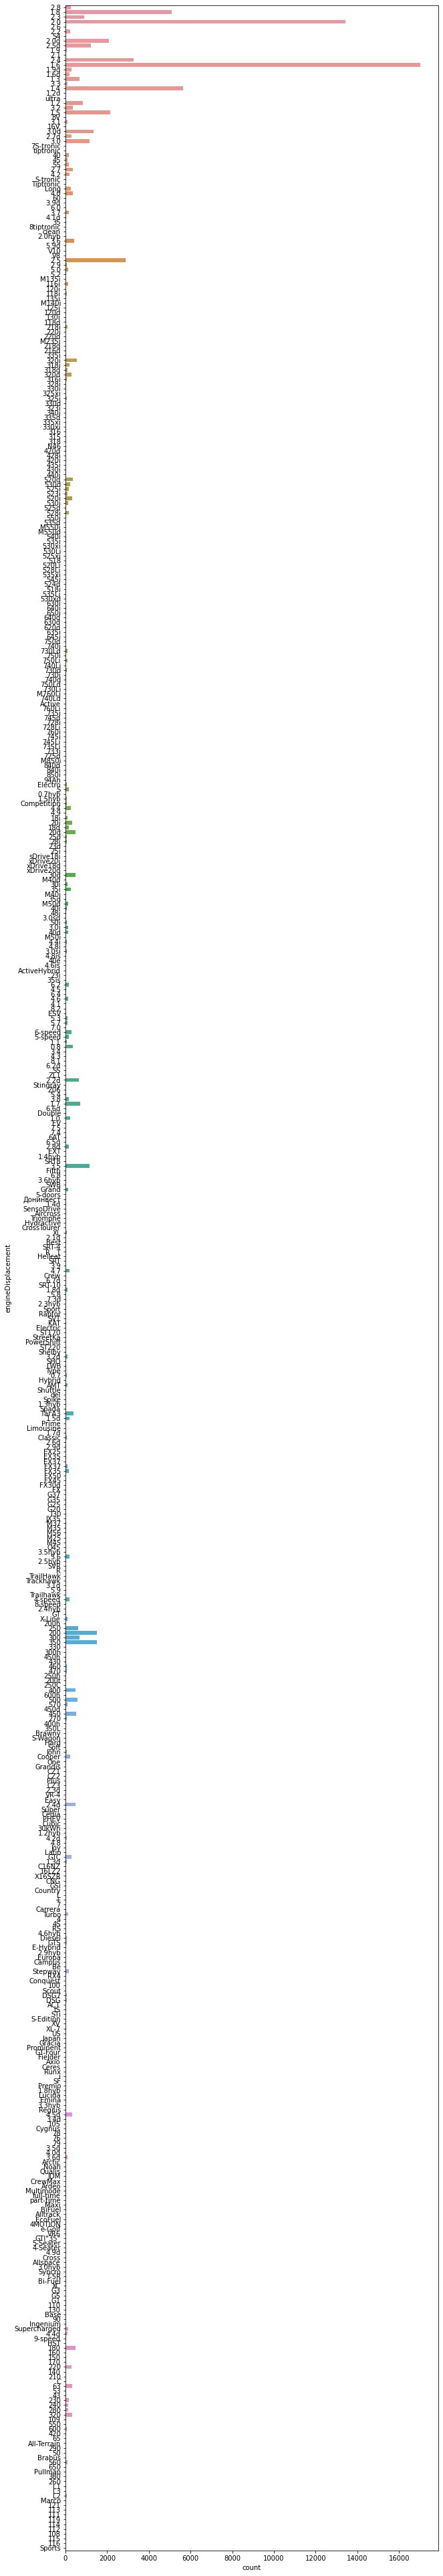

In [23]:
print('Распределение для столбца (не числовой):', ' engineDisplacement')
fig,ax=plt.subplots(figsize=(10,70))
sns.countplot(y=mtrain.loc[:,'engineDisplacement'], ax=ax)
plt.show()

Проверим, что там на самом деле.

In [24]:
mtrain[ 'engineDisplacement' ].unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '16V', '3.0d',
       '2.7d', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '323i', '340i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

In [25]:
mtrain[ 'engineDisplacement' ].value_counts()

1.6           17032
2.0           13446
1.4            5649
1.8            5102
2.4            3272
              ...  
StreetKa          1
PowerShift        1
Shuttle           1
Prime             1
6.7d              1
Name: engineDisplacement, Length: 534, dtype: int64

По опыту, объем двигателя играет важную роль при принятии решения о покупке, поэтому данные стоит очистить. Выделим стандартные числовые показатели объема двигателя, остальные запишем как ноль. Во-первых, их число незначительно по сравнению со стандартными данными, во-вторых, якобы нулевой объем двигателя столь же информативен для массового покупателя, как и непонятные обозначения. Логично предположить, что его влияние будет сравнимо с нулевым показателем.

In [26]:
import re
def func_engineDisplacement(x):
    x1 = re.findall(r'\d\.\d', x)
    # print(x)
    if not x1: return 0
    else: return float(x1[0])
    

In [27]:

mtrain.fillna(value=0, inplace=True)
mtrain['engineDisplacement']=mtrain['engineDisplacement'].apply(lambda x: func_engineDisplacement(x))
mtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89377 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89377 non-null  object 
 2   color                 89377 non-null  object 
 3   fuelType              89377 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89377 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  float64
 11  enginePower           89377 non-null  float64
 12  description           89377 non-null  object 
 13  mileage               89377 non-null  int64  
 14  Комплектация          89377 non-null  object 
 15  Привод             

In [28]:
mtest['engineDisplacement'].value_counts()

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
2.6 LTR      55
 LTR         55
6.0 LTR      53
0.7 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: engineDisplacement, dtype: int64

Здесь данные более чистые, достаточно преобразовать их в числовой вид, учитывая строки, где число отсутствует.

In [29]:
mtest.dropna(subset=['engineDisplacement'], inplace=True)

In [30]:
def func_engineDisplecement_test(x):
    x1 = str(x)[:-4]
    if not x1: return 0
    else: return float(x1)

In [31]:

mtest[ 'engineDisplacement' ] = mtest[ 'engineDisplacement' ].apply(lambda x: func_engineDisplecement_test(x))

In [32]:
mtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   car_url               34686 non-null  object 
 3   color                 34686 non-null  object 
 4   complectation_dict    6418 non-null   object 
 5   description           34686 non-null  object 
 6   engineDisplacement    34686 non-null  float64
 7   enginePower           34686 non-null  object 
 8   equipment_dict        24690 non-null  object 
 9   fuelType              34686 non-null  object 
 10  image                 34686 non-null  object 
 11  mileage               34686 non-null  int64  
 12  modelDate             34686 non-null  int64  
 13  model_info            34686 non-null  object 
 14  model                 34686 non-null  object 
 15  name               

In [33]:
#оставляем только данные в обучающей и тестовой выборке, где цена информативна: больше нуля
mtrain=mtrain[mtrain['price']>0]
train=train[train['price']>0]


Определяем поля - кандидаты для включения в модель

In [34]:
#формируем предварительный список нужных столбцов 
mcolumns=['bodyType', 'brand', 'fuelType', 'modelDate',
       'numberOfDoors', 'productionDate',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'mileage', 'Привод', 'Руль',
       'ПТС', 'price', 
       'model']


In [35]:
#### Удаляем строки с незаполненными значениями важных признаков

mtrain.dropna(subset=['bodyType'], inplace=True)
mtrain.dropna(subset=['Привод'], inplace=True)

**5. 'bodyType'** 

Типы кузова по смыслу одинаковые, но описаны по-разному. Приведем значения к общему виду.

In [36]:
#приводим тип кузова к общим значениям
def rename_body (m):
    m['bodyType']=m['bodyType'].apply(lambda x: str.lower(x))
    m['bodyType']=m['bodyType'].str.replace(' ','')
    m.loc[m['bodyType'].str.contains("внедорожник3"),'bodyType'] =  "Внедорожник3"
    m.loc[m['bodyType'].str.contains("внедорожник5"),'bodyType'] =  "Внедорожник5"
    m.loc[m['bodyType'].str.contains("седанlimousine"),'bodyType'] =  "СеданLong"
    m.loc[m['bodyType'].str.contains("седанlong"),'bodyType'] = "СLong"
    m.loc[m['bodyType'].str.contains("седан-хардтоп"),'bodyType'] = "хардтоп"
    m.loc[m['bodyType'].str.contains("седан"),'bodyType'] = "Седан"    
    m.loc[m['bodyType'].str.contains( "минивэн"),'bodyType'] = "Минивэн"
    m.loc[m['bodyType'].str.contains( "компактвэн"),'bodyType'] = "Минивэн"
    m.loc[m['bodyType'].str.contains("универсал5"),'bodyType']  =  "Универсал5"
    m.loc[m['bodyType'].str.contains("хэтчбек5"),'bodyType'] = "Хэтчбек5"
    m.loc[m['bodyType'].str.contains("хэтчбек4"),'bodyType'] = "Хэтчбек5"
    m.loc[m['bodyType'].str.contains("пикапдв"),'bodyType'] = "Пикап2"
    m.loc[m['bodyType'].str.contains("пикапод"),'bodyType'] = "Пикап1"
    m.loc[m['bodyType'].str.contains("пикаппол"),'bodyType'] = "Пикап1_5"
    m.loc[m['bodyType'].str.contains("фургон"),'bodyType'] = "Фургон"
    m.loc[m['bodyType'].str.contains("родстер"),'bodyType'] = "Родстер"
    m.loc[m['bodyType'].str.contains("тарга"),'bodyType'] = "Родстер"
    m.loc[m['bodyType'].str.contains("кабриолет"),'bodyType'] = "Кабриолет"
    m.loc[m['bodyType'].str.contains("хэтчбек3"),'bodyType'] = "Хэтчбек3"
    m.loc[m['bodyType'].str.contains("лифтбек"),'bodyType'] = "Лифтбек"
    m.loc[m['bodyType'].str.contains("купе "),'bodyType'] = "Купе"
    m.loc[m['bodyType'].str.contains("микровэн"),'bodyType'] = "Микровэн"
    





In [37]:
#применяем измеения к тренировочной и тестовой выборке.
rename_body (mtrain)
rename_body (mtest)

**6. 'brand'**

Цель работы - построение модели для получения наилучшего результата на выборке в kaggle, поэтому есть смысл ограничить обучающую выбрку только брендами, которые присутствуют в тестовой выборке.


In [38]:
#Определили список брендов. Только на этих брендах есть смысл обучать модель
brand_list=mtest.brand.unique()

In [39]:
brand_list

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [40]:
#Сократим обучающую выбрку только до брендов, которые есть в тестовой выборке.
mtrain['brand']=mtrain['brand'].apply(lambda x:str.upper(x))
mtrain['bodyType']=mtrain['bodyType'].str.replace(' ','')

mtrain=mtrain[mtrain['brand'].isin (brand_list)]
mtrain=mtrain[mtrain['price']>0]


**7. Числовые столбцы: посмотрим на распределение и выбросы**

Оставляем 4 числовых столбца: 'productionDate','mileage','enginePower','modelDate'. Плюс преобразованный признак engineDisplacement

До логарифмирования


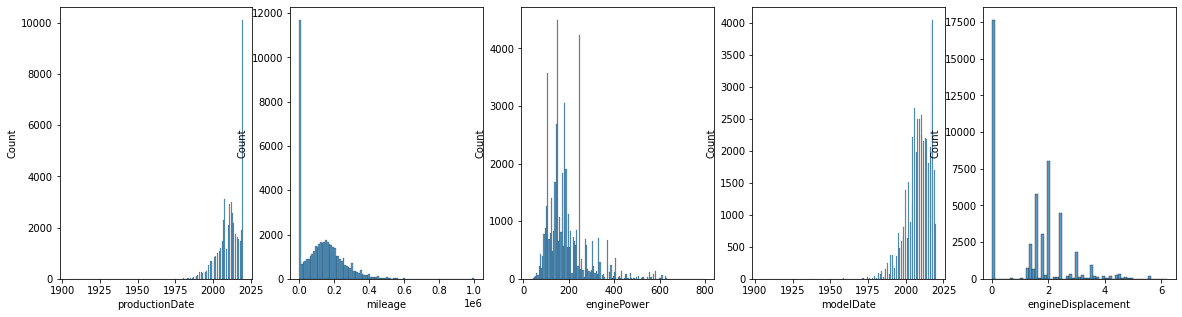

In [41]:

#посмотрим на чиcловые столбцы и прологарифмируем их (эксперимент)
cols_to_ln=['productionDate','mileage','enginePower','modelDate','engineDisplacement']
print ('До логарифмирования')
fig, axes = plt.subplots(1, 5, figsize=(20,5))

for col, i in zip(cols_to_ln, range(5)):   
    sns.histplot(mtrain[col], kde=False, ax=axes.flat[i])
    
plt.show()



После логарифмирования


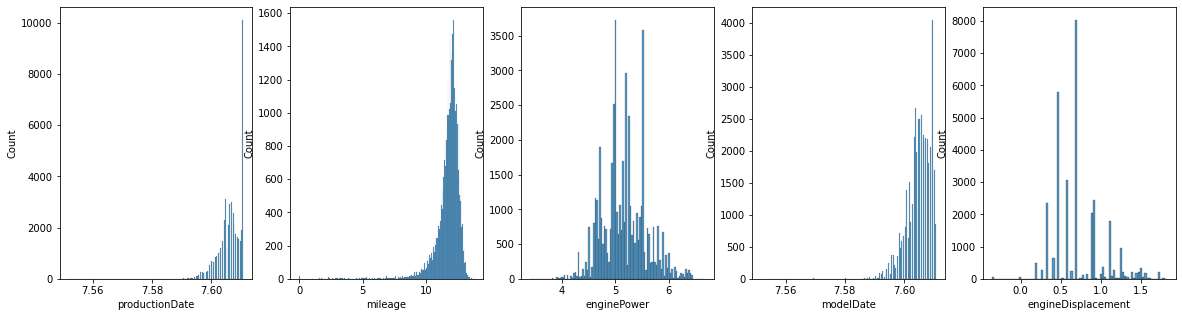

In [42]:
print ('После логарифмирования')
fig, axes = plt.subplots(1, 5, figsize=(20,5))

a=np.log(mtrain[cols_to_ln])
for col, i in zip(cols_to_ln, range(5)):#,'mileage','productionDate'
    
    sns.histplot(a[col], kde=False, ax=axes.flat[i])
    
pylab.show()

In [43]:
mtrain['mileage']=np.log(mtrain['mileage'])
mtest['mileage']=np.log(mtest['mileage'])
mtrain['productionDate']=np.log(mtrain['productionDate'])
mtest['productionDate']=np.log(mtest['productionDate'])
#Для тестовой выборки почистим столбец и преобразуем его в число
mtest['enginePower']=mtest['enginePower'].apply(lambda x: int(x[:-3].strip()))
mtrain['enginePower']=np.log(mtrain['enginePower'])
mtest['enginePower']=np.log(mtest['enginePower'])
mtrain['modelDate']=np.log(mtrain['modelDate'])
mtest['modelDate']=np.log(mtest['modelDate'])
mtrain['engineDisplacement']=np.log(mtrain['engineDisplacement'])
mtest['engineDisplacement']=np.log(mtest['engineDisplacement'])
mtest=mtest.replace(-np.Inf, 0)
mtest=mtest.replace(np.NINF, 0)
mtest=mtest.replace(np.Inf, 0)
mtrain=mtrain.replace(-np.Inf, 0)
mtrain=mtrain.replace(np.NINF, 0)
mtrain=mtrain.replace(np.Inf, 0)

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Data Preprocessing

In [44]:
train.dropna(subset=['productionDate','mileage','Руль','Привод','enginePower',
                     'modelDate','fuelType','numberOfDoors','vehicleTransmission','model'], inplace=True)
train.dropna(subset=['price'], inplace=True)

mtrain.dropna(subset=['productionDate','mileage','Руль','Привод','enginePower',
                      'modelDate','fuelType','numberOfDoors','vehicleTransmission','model'], inplace=True)
mtrain.dropna(subset=['price'], inplace=True)

mtrain=mtrain[mtrain['price']>0]


In [45]:
columns = ['bodyType', 'brand', 'productionDate',  'mileage','Руль',
           'Привод','enginePower','modelDate','fuelType','numberOfDoors','vehicleTransmission','model','engineDisplacement']
df_train = mtrain[columns]
df_test = mtest[columns]

In [46]:
y = mtrain['price']

## Label Encoding

In [47]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
mdata = data.copy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**8. 'Руль'**
Приведем данные к одинаковым значениям

In [48]:
data['Руль']=data['Руль'].apply(lambda x: 'LEFT' if x =='Левый' else 'RIGHT')

for colum in ['bodyType', 'brand', 'Руль','Привод','fuelType','numberOfDoors','vehicleTransmission','model']:
    data[colum] = data[colum].astype('category').cat.codes #'engineDisplacement',


**9. 'model'** 
Есть смысл сравнить списки моделей из обучающей и тестовой выборок, сравнить 2 множества, посмотерть пересечение. Исключений не очень много, признак оставим, модель сильно влияет на стоимость авто.

In [49]:
tr=mtrain.model.unique().tolist()
ts=mtest.model.unique().tolist()
result=list(set(ts) - set(tr))
sorted(result)

['300ZX',
 'ARTEON',
 'ATLAS',
 'COROLLA_II',
 'GOLF_R32',
 'IST',
 'LANCER_RALLIART',
 'LM',
 'OTTI',
 'POLO_GTI',
 'PORTE',
 'PRESEA',
 'RSQ3',
 'SPARKY',
 'TORNEO',
 'WILL_CYPHA',
 'X4_M',
 'Z',
 'ZEST']

In [50]:
data.sample(5)

,bodyType,brand,productionDate,mileage,Руль,Привод,enginePower,modelDate,fuelType,numberOfDoors,vehicleTransmission,model,engineDisplacement,sample
31366,11,11,7.603898,12.128111,0,1,5.135798,7.602401,0,3,0,430,0.875469,0
71742,1,10,7.610853,0.000000,1,1,4.828314,7.608871,0,4,1,488,0.336472,1
28153,1,6,7.606387,11.982929,0,2,5.181784,7.606387,0,4,0,338,1.098612,0
24472,1,10,7.610358,10.596635,0,2,5.393628,7.608871,0,4,2,488,0.693147,0
63490,12,9,7.604396,11.877569,1,1,4.700480,7.603898,0,4,3,127,0.000000,1


In [51]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

In [52]:
union_data = mtest.append(mtrain, sort=False).reset_index(drop=True) # объединяем

## Train Split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим первую модель 
Эта модель будет предсказывать среднюю цену по отобранным ранее признакам.



In [54]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

# # Model 1 : CatBoost

У нас много категориальных признаков. Специально для работы с такими данными есть библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     


## Fit

In [55]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [56]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 14.16%


На обработанных и отобранных признаках получили ошибку в 14%. 

### Log Traget
Попробуем взять таргет в Log - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
Также в этой модели используем параметры, подобранные по сетке. 

In [57]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         depth = 10, l2_leaf_reg = 7, learning_rate = 0.1)
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [58]:
#Оптимизируем гиперпараметры
#model_random = CatBoostRegressor()
#grid = {'learning_rate': [0.1, 0.2,0.3],
#        'depth': [ 6,8,10,12],
#        'l2_leaf_reg': [3,5,  7,9]}

#search_result = model_random.grid_search(grid, X=X_train, y=y_train, verbose=3, plot=True)
#print(search_result['params'])

In [59]:
#search_result['params']
#grid_cv = model_selection.GridSearchCV(CatBoostRegressor(), parameters_grid, scoring = 'MAPE', cv = cv)
#grid_cv.fit(X_train, X_test)

In [60]:
#model_random.best_params_

In [61]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [62]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 11.91%


## Пробуем другие ML модели: 
1.Подготовка train: labelIncoding


In [63]:
mdata.info()
cat_cols = ['bodyType', 'brand', 'Руль','Привод','fuelType','numberOfDoors','vehicleTransmission','model']#
num_cals=['productionDate','mileage','enginePower', 'modelDate','engineDisplacement']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83786 entries, 0 to 83785
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             83786 non-null  object 
 1   brand                83786 non-null  object 
 2   productionDate       83786 non-null  float64
 3   mileage              83786 non-null  float64
 4   Руль                 83786 non-null  object 
 5   Привод               83786 non-null  object 
 6   enginePower          83786 non-null  float64
 7   modelDate            83786 non-null  float64
 8   fuelType             83786 non-null  object 
 9   numberOfDoors        83786 non-null  float64
 10  vehicleTransmission  83786 non-null  object 
 11  model                83786 non-null  object 
 12  engineDisplacement   83786 non-null  float64
 13  sample               83786 non-null  int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 8.9+ MB


Построим матрицу корреляций по чилосвым столбцам

<AxesSubplot:>

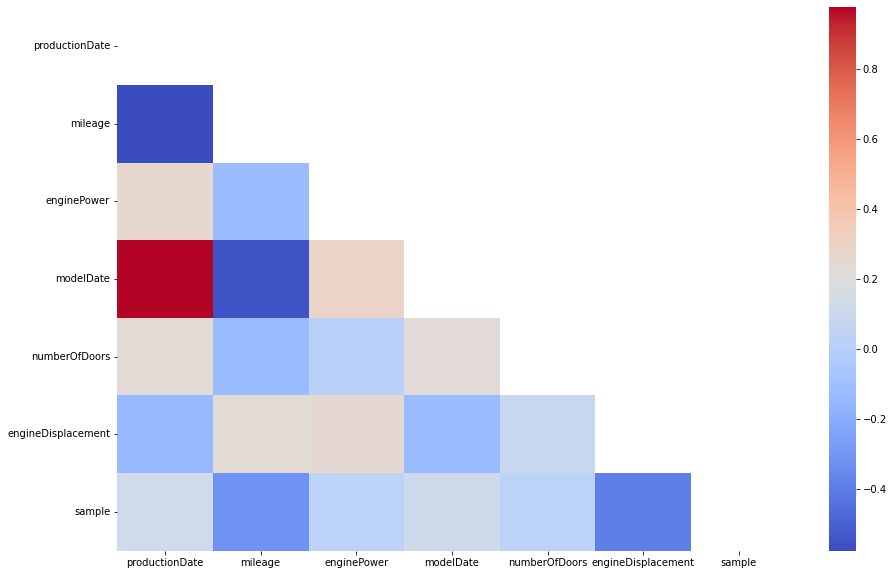

In [64]:
plt.rcParams['figure.figsize'] = (15,10)

matrix = np.triu(mdata[mdata['sample'] == 0].corr())
sns.heatmap(mdata.corr(), annot=False, mask=matrix, cmap= 'coolwarm')

Видим, что дата выпуска сильно коррелирует с датой модели. Однако, при удалении одного из признаков ощутимо снижаетсяя оценка. Оставляем оба признака и позже проверим, возможно, из 2 признаков можно сделать 1.
Также есть достаточно сильная обратная корелляция этих признаков с пробегом.

In [65]:
#Определяем dummy-переменные
dummies = pd.get_dummies(mdata[cat_cols])

In [66]:
mdata_dum = pd.concat([mdata, dummies], axis=1)

In [67]:
mdata_dum.sample(5)

,bodyType,brand,productionDate,mileage,Руль,Привод,enginePower,modelDate,fuelType,numberOfDoors,vehicleTransmission,model,engineDisplacement,sample,numberOfDoors,bodyType_Внедорожник3,bodyType_Внедорожник5,bodyType_Кабриолет,bodyType_Лифтбек,bodyType_Микровэн,bodyType_Минивэн,bodyType_Пикап1,bodyType_Пикап1_5,bodyType_Пикап2,bodyType_Родстер,bodyType_СLong,bodyType_Седан,bodyType_Универсал5,bodyType_Фургон,bodyType_Хэтчбек3,bodyType_Хэтчбек5,bodyType_внедорожникоткрытый,bodyType_купе,bodyType_купе-хардтоп,bodyType_купеasti,bodyType_лимузин,bodyType_лимузинpullman,bodyType_фастбек,bodyType_хардтоп,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO,Руль_LEFT,Руль_RIGHT,Руль_Левый,Руль_Правый,Привод_задний,Привод_передний,Привод_полный,fuelType_бензин,fuelType_газ,fuelType_гибрид,fuelType_дизель,fuelType_электро,vehicleTransmission_AUTOMATIC,vehicleTransmission_MECHANICAL,vehicleTransmission_ROBOT,vehicleTransmission_VARIATOR,model_02,model_100,model_100NX,model_100_SERIES,model_120,model_140,model_180SX,model_190_SL,model_1ER,model_200,model_200SX,model_240_SERIES,model_280ZX,model_2ACTIVETOURER,model_2ER,model_2GRANDTOURER,model_300ZX,model_321,model_326,model_340,model_350Z,model_3ER,model_4,model_440,model_460,model_4RUNNER,model_5ER,model_6ER,model_740,model_760,model_7ER,model_80,model_850,model_8ER,model_90,model_920,model_940,model_960,model_A1,model_A2,model_A3,model_A4,model_A4_ALLROAD,model_A5,model_A6,model_A7,model_A8,model_ACCORD,model_ACTY,model_AD,model_AIRTREK,model_AIRWAVE,model_ALLEX,model_ALLROAD,model_ALMERA,model_ALMERA_CLASSIC,model_ALMERA_TINO,model_ALPHARD,model_ALTEZZA,model_ALTIMA,model_AMAROK,model_AMG_GLC_COUPE,model_AMG_GT,model_AQUA,model_ARISTO,model_ARMADA,model_ARTEON,model_ASCOT,model_ASPIRE,model_ASX,model_ATLAS,model_AURIS,model_AVALON,model_AVANCIER,model_AVENIR,model_AVENSIS,model_AVENSIS_VERSO,model_AYGO,model_A_KLASSE,model_A_KLASSE_AMG,model_BASSARA,model_BB,model_BEETLE,model_BLADE,model_BLUEBIRD,model_BLUEBIRD_SYLPHY,model_BORA,model_BREVIS,model_B_KLASSE,model_C30,model_C70,model_CADDY,model_CALDINA,model_CALIFORNIA,model_CAMI,model_CAMRY,model_CAMRY_SOLARA,model_CARAVAN_COACH,model_CARAVELLE,model_CARINA,model_CARINA_E,model_CARINA_ED,model_CARISMA,model_CAVALIER,model_CEDRIC,model_CEFIRO,model_CELICA,model_CELSIOR,model_CHARIOT,model_CHASER,model_CITAN,model_CITY,model_CIVIC,model_CIVIC_FERIO,model_CIVIC_TYPE_R,model_CLA_KLASSE,model_CLA_KLASSE_AMG,model_CLC_KLASSE,model_CLIPPER,model_CLIPPER_RIO,model_CLK_KLASSE,model_CLS_KLASSE,model_CLS_KLASSE_AMG,model_CL_KLASSE,model_CL_KLASSE_AMG,model_COLT,model_CONCERTO,model_COROLLA,model_COROLLA_II,model_COROLLA_LEVIN,model_COROLLA_RUMION,model_COROLLA_SPACIO,model_COROLLA_VERSO,model_CORONA,model_CORONA_EXIV,model_CORRADO,model_CORSA,model_COUPE,model_CRESTA,model_CROSSROAD,model_CROSSTOUR,model_CROWN,model_CROWN_MAJESTA,model_CR_V,model_CR_X,model_CR_Z,model_CT,model_CUBE,model_CURREN,model_CYNOS,model_C_HR,model_C_KLASSE,model_C_KLASSE_AMG,model_DATSUN,model_DAYZ,model_DAYZ_ROOX,model_DELICA,model_DELICA_D2,model_DELICA_D_5,model_DIAMANTE,model_DINGO,model_DION,model_DOMANI,model_DUET,model_E3,model_ECHO,model_ECLIPSE,model_ECLIPSE_CROSS,model_EDIX,model_EK_WAGON,model_ELEMENT,model_ELGRAND,model_ELYSION,model_EMERAUDE,model_ENDEAVOR,model_EOS,model_EQC,model_ES,model_ESQUIRE,model_ESTIMA,model_EUROVAN,model_EX,model_EXPERT,model_E_KLASSE,model_E_KLASSE_AMG,model_E_TRON,model_FABIA,model_FABIA_RS,model_FAIRLADY_Z,model_FAVORIT,model_FELICIA,model_FIT,model_FJ_CRUISER,model_FORTUNER,model_FOX,model_FREED,model_FR_V,model_FTO,model_FUGA,model_FUNCARGO,model_FX,model_G35,model_GAIA,model_GALANT,model_GLA_CLASS,model_GLA_CLASS_AMG,model_GLB_KLASSE,model_GLC_COUPE,model_GLC_KLASSE,model_GLC_KLASSE_AMG,model_GLE_KLASSE,model_GLE_KLASSE_AMG,model_GLE_KLASSE_COUPE,model_GLE_KLASSE_COUPE_AMG,model_GLK_KLASSE,model_GLORIA,model_GLS_KLASSE,mo

In [68]:
mdata_d = mdata_dum.drop(columns=cat_cols, axis=1)

In [69]:
mdata_d.sample(5)

,productionDate,mileage,enginePower,modelDate,engineDisplacement,sample,bodyType_Внедорожник3,bodyType_Внедорожник5,bodyType_Кабриолет,bodyType_Лифтбек,bodyType_Микровэн,bodyType_Минивэн,bodyType_Пикап1,bodyType_Пикап1_5,bodyType_Пикап2,bodyType_Родстер,bodyType_СLong,bodyType_Седан,bodyType_Универсал5,bodyType_Фургон,bodyType_Хэтчбек3,bodyType_Хэтчбек5,bodyType_внедорожникоткрытый,bodyType_купе,bodyType_купе-хардтоп,bodyType_купеasti,bodyType_лимузин,bodyType_лимузинpullman,bodyType_фастбек,bodyType_хардтоп,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO,Руль_LEFT,Руль_RIGHT,Руль_Левый,Руль_Правый,Привод_задний,Привод_передний,Привод_полный,fuelType_бензин,fuelType_газ,fuelType_гибрид,fuelType_дизель,fuelType_электро,vehicleTransmission_AUTOMATIC,vehicleTransmission_MECHANICAL,vehicleTransmission_ROBOT,vehicleTransmission_VARIATOR,model_02,model_100,model_100NX,model_100_SERIES,model_120,model_140,model_180SX,model_190_SL,model_1ER,model_200,model_200SX,model_240_SERIES,model_280ZX,model_2ACTIVETOURER,model_2ER,model_2GRANDTOURER,model_300ZX,model_321,model_326,model_340,model_350Z,model_3ER,model_4,model_440,model_460,model_4RUNNER,model_5ER,model_6ER,model_740,model_760,model_7ER,model_80,model_850,model_8ER,model_90,model_920,model_940,model_960,model_A1,model_A2,model_A3,model_A4,model_A4_ALLROAD,model_A5,model_A6,model_A7,model_A8,model_ACCORD,model_ACTY,model_AD,model_AIRTREK,model_AIRWAVE,model_ALLEX,model_ALLROAD,model_ALMERA,model_ALMERA_CLASSIC,model_ALMERA_TINO,model_ALPHARD,model_ALTEZZA,model_ALTIMA,model_AMAROK,model_AMG_GLC_COUPE,model_AMG_GT,model_AQUA,model_ARISTO,model_ARMADA,model_ARTEON,model_ASCOT,model_ASPIRE,model_ASX,model_ATLAS,model_AURIS,model_AVALON,model_AVANCIER,model_AVENIR,model_AVENSIS,model_AVENSIS_VERSO,model_AYGO,model_A_KLASSE,model_A_KLASSE_AMG,model_BASSARA,model_BB,model_BEETLE,model_BLADE,model_BLUEBIRD,model_BLUEBIRD_SYLPHY,model_BORA,model_BREVIS,model_B_KLASSE,model_C30,model_C70,model_CADDY,model_CALDINA,model_CALIFORNIA,model_CAMI,model_CAMRY,model_CAMRY_SOLARA,model_CARAVAN_COACH,model_CARAVELLE,model_CARINA,model_CARINA_E,model_CARINA_ED,model_CARISMA,model_CAVALIER,model_CEDRIC,model_CEFIRO,model_CELICA,model_CELSIOR,model_CHARIOT,model_CHASER,model_CITAN,model_CITY,model_CIVIC,model_CIVIC_FERIO,model_CIVIC_TYPE_R,model_CLA_KLASSE,model_CLA_KLASSE_AMG,model_CLC_KLASSE,model_CLIPPER,model_CLIPPER_RIO,model_CLK_KLASSE,model_CLS_KLASSE,model_CLS_KLASSE_AMG,model_CL_KLASSE,model_CL_KLASSE_AMG,model_COLT,model_CONCERTO,model_COROLLA,model_COROLLA_II,model_COROLLA_LEVIN,model_COROLLA_RUMION,model_COROLLA_SPACIO,model_COROLLA_VERSO,model_CORONA,model_CORONA_EXIV,model_CORRADO,model_CORSA,model_COUPE,model_CRESTA,model_CROSSROAD,model_CROSSTOUR,model_CROWN,model_CROWN_MAJESTA,model_CR_V,model_CR_X,model_CR_Z,model_CT,model_CUBE,model_CURREN,model_CYNOS,model_C_HR,model_C_KLASSE,model_C_KLASSE_AMG,model_DATSUN,model_DAYZ,model_DAYZ_ROOX,model_DELICA,model_DELICA_D2,model_DELICA_D_5,model_DIAMANTE,model_DINGO,model_DION,model_DOMANI,model_DUET,model_E3,model_ECHO,model_ECLIPSE,model_ECLIPSE_CROSS,model_EDIX,model_EK_WAGON,model_ELEMENT,model_ELGRAND,model_ELYSION,model_EMERAUDE,model_ENDEAVOR,model_EOS,model_EQC,model_ES,model_ESQUIRE,model_ESTIMA,model_EUROVAN,model_EX,model_EXPERT,model_E_KLASSE,model_E_KLASSE_AMG,model_E_TRON,model_FABIA,model_FABIA_RS,model_FAIRLADY_Z,model_FAVORIT,model_FELICIA,model_FIT,model_FJ_CRUISER,model_FORTUNER,model_FOX,model_FREED,model_FR_V,model_FTO,model_FUGA,model_FUNCARGO,model_FX,model_G35,model_GAIA,model_GALANT,model_GLA_CLASS,model_GLA_CLASS_AMG,model_GLB_KLASSE,model_GLC_COUPE,model_GLC_KLASSE,model_GLC_KLASSE_AMG,model_GLE_KLASSE,model_GLE_KLASSE_AMG,model_GLE_KLASSE_COUPE,model_GLE_KLASSE_COUPE_AMG,model_GLK_KLASSE,model_GLORIA,model_GLS_KLASSE,model_GLS_KLASSE_AMG,model_GL_KLASSE,model_GL_KLASSE_AMG,model_GOLF,model_GOLF_GTI,model_GOL

In [70]:
XX = mdata_d.query('sample == 1').drop(['sample'], axis=1)
XX_sub = mdata_d.query('sample == 0').drop(['sample'], axis=1)

# Splitting the data
XX_train, X_val, yy_train, y_val = train_test_split(XX, y,  test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [71]:
yy_train=np.log(yy_train)

In [72]:
XX_train=XX_train.astype(float)
y_train=y_train.astype(float)
XX_train=XX_train.replace(-np.Inf, 0)
XX_train=XX_train.replace(np.NINF, 0)
XX_train=XX_train.replace(np.Inf, 0)
y_train=y_train.replace(-np.Inf, 0)
y_train=y_train.replace(np.NINF, 0)
y_train=y_train.replace(np.Inf, 0)
yy_train=yy_train.replace(-np.Inf, 0)
yy_train=yy_train.replace(np.NINF, 0)
yy_train=yy_train.replace(np.Inf, 0)

### XGBRegressor. 
Гиперпараметры были подобраны опытным путем, поскольку подбор по сетке занимал очень много времени.

In [73]:

xg_reg = xgb.XGBRegressor ( colsample_bytree= 0.7, 
                            learning_rate= 0.03, 
                            max_depth= 12, 
                            min_child_weight = 4, 
                            n_estimators = 500, 
                            nthread = 4, 
                            
                            subsample = 0.7)

#(objective='reg:squarederror', colsample_bytree=0.5,
#                          learning_rate=0.05, max_depth=12, alpha=1,
#                          n_estimators=1000)
xg_reg.fit(XX_train, yy_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=12, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
predict_xg_reg = xg_reg.predict(X_val)
predict_xg_reg_sub = np.exp(xg_reg.predict(XX_sub))
#np.exp(model.predict(X_sub))
#display(predict)
#display(y_test)
print(f"Точность модели по метрике MAPE: {(mape(y_val, np.exp(predict_xg_reg)))*100:0.2f}%")

Точность модели по метрике MAPE: 12.06%


### Случайный лес

In [75]:
#  Random Forest
rf = ExtraTreesRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1,
                         bootstrap=True, verbose=1)
rf.fit(XX_train, yy_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.4min finished


ExtraTreesRegressor(bootstrap=True, n_estimators=300, n_jobs=-1,
                    random_state=42, verbose=1)

In [76]:
pred_rf = rf.predict(X_val)
pred_rf_sub=np.exp(rf.predict(XX_sub))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.2s finished


In [77]:
MAPE = mape(y_test, pred_rf)
print(f"Точность модели по метрике MAPE: {(mape(y_val, np.exp(pred_rf)))*100:0.2f}%")
#print(f'Mean Absolute Percentage Error: {MAPE}')

Точность модели по метрике MAPE: 12.33%


### GradientBoostingRegressor

In [78]:
gbr = GradientBoostingRegressor(loss ='ls',n_estimators = 900, max_depth=10)
gbr.fit (XX_train, yy_train)

pred_gbr = gbr.predict(X_val)
pred_gbr_sub= np.exp(gbr.predict(XX_sub))

In [79]:
print(f"Точность модели по метрике MAPE: {(mape(y_val, np.exp(pred_gbr)))*100:0.2f}%")

Точность модели по метрике MAPE: 12.20%


In [80]:
pred_gbr_sub

array([ 626678.9327846 ,  919516.92073686,  848619.94818567, ...,
        255455.52198437, 1008325.91497874, 1097551.53792743])

In [81]:
#GradientBoosting на  датасете, подготовленном для catboost
gbr = GradientBoostingRegressor(loss ='ls', max_depth=10, n_estimators = 1100)
gbr.fit (X_train, y_train)

GradientBoostingRegressor(max_depth=10, n_estimators=1100)

In [82]:
pred_gbr_1 = gbr.predict(X_test)
pred_gbr1_sub= gbr.predict(X_sub)
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_gbr_1))*100:0.2f}%")

Точность модели по метрике MAPE: 13.92%


pred_stack = clf.predict(X_test)
pred_stack_sub=np.exp(clf.predict(X_sub))

#подбор гиперпараметров для GradientBoostingRegressor
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100]

# Maximum depth of each tree
max_depth = [5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [ 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features}

# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
GScv = GridSearchCV(model, hyperparameter_grid ,cv = 2, n_jobs = -1, verbose=True)

# Fit on the training data
GScv.fit(X_train, y_train) 
#After performing the search, we can inspect the RandomizedSearchCV object to find the best model:


# Submission

In [83]:
sample_submission['price'] = pred_gbr_sub
sample_submission.to_csv(f'submission.csv', index=False)
#sample_submission.head(10)
#sample_submission['price'] = pred_rf_sub#*1.11
#sample_submission.to_csv(f'submission.csv', index=False)

In [84]:
sample_submission.to_csv('sample_submission.csv')

In [85]:
sample_submission

,sell_id,price
0,1100575026,6.266789e+05
1,1100549428,9.195169e+05
2,1100658222,8.486199e+05
3,1100937408,7.337480e+05
4,1101037972,6.759508e+05
...,...,...
34681,1101369263,1.000687e+06
34682,1101369581,2.397893e+06
34683,1101364889,2.554555e+05
34684,1101362518,1.008326e+06


В итоге получили **MAPE 12,177%** 

Есть небольшая разница в размере ошибки между test и submission, которая наименее заметна при использовании  GradientBoostingRegressor.